In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from numpy import mean
from numpy import std

from sklearn.model_selection import GridSearchCV




In [2]:
# get data
result_df = pd.read_csv(r'f1db_csv/results.csv')
stats_df = pd.read_csv(r'f1db_csv/status.csv')
drivers_df = pd.read_csv(r'f1db_csv/drivers.csv')
races_df = pd.read_csv(r'f1db_csv/races.csv')
constructor_df = pd.read_csv(r'f1db_csv/constructors.csv')
driver_standings_df = pd.read_csv(r'f1db_csv/driver_standings.csv')
constructor_standings_df = pd.read_csv(r'f1db_csv/constructor_standings.csv')

pd.get_option("display.max_columns",None)

20

In [3]:
races_df = races_df.drop(races_df.columns[[ 3, 5, 6, 7]], axis=1)
col_name = {'name':'gpName', 'positionText':'finishPosition'}
races_df.rename(columns=col_name,inplace=True)
races_df.head()

,raceId,year,round,gpName
0,1,2009,1,Australian Grand Prix
1,2,2009,2,Malaysian Grand Prix
2,3,2009,3,Chinese Grand Prix
3,4,2009,4,Bahrain Grand Prix
4,5,2009,5,Spanish Grand Prix


In [4]:
result_df = result_df.drop(columns=['resultId','position','number','positionOrder', 'laps', 'milliseconds','time', 'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'points'])
col_name = {'grid':'startPosition', 'positionText':'finishPosition'}
result_df.rename(columns=col_name,inplace=True)
result_df.head(20)

,raceId,driverId,constructorId,startPosition,finishPosition,statusId
0,1063,830,9,1,1,1
1,1063,847,3,2,2,1
2,1063,1,131,3,3,1
3,1063,817,1,4,4,1
4,1063,20,117,5,5,1
5,1063,842,213,6,6,1
6,1063,839,214,8,7,1
7,1063,844,6,9,8,1
8,1063,849,3,10,9,1
9,1063,832,6,11,10,1


In [5]:
con1 = pd.merge(races_df, result_df, on ='raceId')
con1.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId
0,1,2009,1,Australian Grand Prix,18,23,1,1,1
1,1,2009,1,Australian Grand Prix,22,23,2,2,1
2,1,2009,1,Australian Grand Prix,15,7,20,3,1
3,1,2009,1,Australian Grand Prix,10,7,19,4,1
4,1,2009,1,Australian Grand Prix,4,4,10,5,1


In [6]:
drivers_df['driverName'] = drivers_df['forename']+' '+drivers_df['surname']
drivers_df = drivers_df.drop(columns=['number','dob', 'url', 'forename','surname', 'code', 'driverRef', 'nationality'])
#drivers_df.rename(columns={'nationality':'nationalityDriver'},inplace=True)
drivers_df.head()

,driverId,driverName
0,1,Lewis Hamilton
1,2,Nick Heidfeld
2,3,Nico Rosberg
3,4,Fernando Alonso
4,5,Heikki Kovalainen


In [7]:
con2 = pd.merge(con1, drivers_df, on ='driverId')
con2.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId,driverName
0,1,2009,1,Australian Grand Prix,18,23,1,1,1,Jenson Button
1,2,2009,2,Malaysian Grand Prix,18,23,1,1,1,Jenson Button
2,3,2009,3,Chinese Grand Prix,18,23,5,3,1,Jenson Button
3,4,2009,4,Bahrain Grand Prix,18,23,4,1,1,Jenson Button
4,5,2009,5,Spanish Grand Prix,18,23,1,1,1,Jenson Button


In [8]:
constructor_df = constructor_df.drop(columns=['constructorRef','nationality', 'url'])
constructor_df.rename(columns={'name':'constructorName'},inplace=True)
constructor_df.head()

,constructorId,constructorName
0,1,McLaren
1,2,BMW Sauber
2,3,Williams
3,4,Renault
4,5,Toro Rosso


In [9]:
con3 = pd.merge(con2, constructor_df, on ='constructorId')
con3.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId,driverName,constructorName
0,1,2009,1,Australian Grand Prix,18,23,1,1,1,Jenson Button,Brawn
1,2,2009,2,Malaysian Grand Prix,18,23,1,1,1,Jenson Button,Brawn
2,3,2009,3,Chinese Grand Prix,18,23,5,3,1,Jenson Button,Brawn
3,4,2009,4,Bahrain Grand Prix,18,23,4,1,1,Jenson Button,Brawn
4,5,2009,5,Spanish Grand Prix,18,23,1,1,1,Jenson Button,Brawn


In [10]:
driver_standings_df = driver_standings_df.drop(columns=['driverStandingsId','points','position'])
col_name = {'positionText':'driverChampPosition', 'wins':'driverWins'}
driver_standings_df.rename(columns=col_name,inplace=True)
driver_standings_df.head()

,raceId,driverId,driverChampPosition,driverWins
0,18,1,1,1
1,18,2,2,0
2,18,3,3,0
3,18,4,4,0
4,18,5,5,0


In [11]:
con4 = pd.merge(con3, driver_standings_df, on =['raceId', 'driverId'])
con4.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId,driverName,constructorName,driverChampPosition,driverWins
0,1,2009,1,Australian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,1
1,2,2009,2,Malaysian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,2
2,3,2009,3,Chinese Grand Prix,18,23,5,3,1,Jenson Button,Brawn,1,2
3,4,2009,4,Bahrain Grand Prix,18,23,4,1,1,Jenson Button,Brawn,1,3
4,5,2009,5,Spanish Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,4


In [12]:
constructor_standings_df = constructor_standings_df.drop(columns=['position', 'constructorStandingsId', 'points'])
col_name = {'positionText':'teamChampPosition', 'wins':'constructorWins'}
constructor_standings_df.rename(columns=col_name,inplace=True)
constructor_standings_df.head()

,raceId,constructorId,teamChampPosition,constructorWins
0,18,1,1,1
1,18,2,3,0
2,18,3,2,0
3,18,4,4,0
4,18,5,5,0


In [13]:
con5 = pd.merge(con4, constructor_standings_df, on =['raceId', 'constructorId'])
con5.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins
0,1,2009,1,Australian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,1,1,1
1,1,2009,1,Australian Grand Prix,22,23,2,2,1,Rubens Barrichello,Brawn,2,0,1,1
2,2,2009,2,Malaysian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,2,1,2
3,2,2009,2,Malaysian Grand Prix,22,23,8,5,1,Rubens Barrichello,Brawn,2,0,1,2
4,3,2009,3,Chinese Grand Prix,18,23,5,3,1,Jenson Button,Brawn,1,2,1,2


In [14]:
stats_df.head()

,statusId,status
0,1,Finished
1,2,Disqualified
2,3,Accident
3,4,Collision
4,5,Engine


In [15]:
df = pd.merge(con5, stats_df, on ='statusId')
df.head()

,raceId,year,round,gpName,driverId,constructorId,startPosition,finishPosition,statusId,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,status
0,1,2009,1,Australian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,1,1,1,Finished
1,1,2009,1,Australian Grand Prix,22,23,2,2,1,Rubens Barrichello,Brawn,2,0,1,1,Finished
2,2,2009,2,Malaysian Grand Prix,18,23,1,1,1,Jenson Button,Brawn,1,2,1,2,Finished
3,2,2009,2,Malaysian Grand Prix,22,23,8,5,1,Rubens Barrichello,Brawn,2,0,1,2,Finished
4,3,2009,3,Chinese Grand Prix,18,23,5,3,1,Jenson Button,Brawn,1,2,1,2,Finished


In [16]:
df = df.drop(columns=['raceId', 'driverId', 'constructorId', 'statusId'])
df.head()

,year,round,gpName,startPosition,finishPosition,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,status
0,2009,1,Australian Grand Prix,1,1,Jenson Button,Brawn,1,1,1,1,Finished
1,2009,1,Australian Grand Prix,2,2,Rubens Barrichello,Brawn,2,0,1,1,Finished
2,2009,2,Malaysian Grand Prix,1,1,Jenson Button,Brawn,1,2,1,2,Finished
3,2009,2,Malaysian Grand Prix,8,5,Rubens Barrichello,Brawn,2,0,1,2,Finished
4,2009,3,Chinese Grand Prix,5,3,Jenson Button,Brawn,1,2,1,2,Finished


<h2>Data Preprocessing</h2>

In [17]:
# check null values - not really indicative
df.isna().sum()

year                   0
round                  0
gpName                 0
startPosition          0
finishPosition         0
driverName             0
constructorName        0
driverChampPosition    0
driverWins             0
teamChampPosition      0
constructorWins        0
status                 0
dtype: int64

In [18]:
print(df.duplicated().sum())
df.shape

0


(23319, 12)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23319 entries, 0 to 23318
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   year                 23319 non-null  int64 
 1   round                23319 non-null  int64 
 2   gpName               23319 non-null  object
 3   startPosition        23319 non-null  int64 
 4   finishPosition       23319 non-null  object
 5   driverName           23319 non-null  object
 6   constructorName      23319 non-null  object
 7   driverChampPosition  23319 non-null  object
 8   driverWins           23319 non-null  int64 
 9   teamChampPosition    23319 non-null  object
 10  constructorWins      23319 non-null  int64 
 11  status               23319 non-null  object
dtypes: int64(5), object(7)
memory usage: 2.3+ MB


In [20]:
df.columns

Index(['year', 'round', 'gpName', 'startPosition', 'finishPosition',
       'driverName', 'constructorName', 'driverChampPosition', 'driverWins',
       'teamChampPosition', 'constructorWins', 'status'],
      dtype='object')

In [21]:
print(df['finishPosition'].unique())
print(df['driverChampPosition'].unique())
print(df['teamChampPosition'].unique())

['1' '2' '5' '3' '4' '6' '7' '10' '8' '11' '15' '9' '12' '13' '14' '16'
 '17' '19' '18' '20' 'R' 'W' 'D' '22' '21' '23' 'N' '24' 'F' 'E']
['1' '2' '4' '3' '13' '16' '12' '14' '15' '10' '18' '17' '19' '6' '9' '8'
 '7' '5' '11' '22' '20' '21' '25' '26' '23' '24' '31' '30' '35' '27' '29'
 '28' '34' '33' '42' '32' '37' '38' '41' '36' '43' '45' '39' '53' '77'
 '46' '47' '49' 'D' '40' '48' '44' '75' '54' '60' '63' '57' '50' '78' '59'
 '80' '51' '64' '66' '58' '69' '56' '67' '61' '81' '52' '55' '71' '62'
 '68' '83' '73' '76' '70']
['1' '9' '8' '4' '7' '5' '6' '3' '2' '10' '12' 'E' '11' '13' '18' '15'
 '14' '16' '17' '19' '21' '20']


In [22]:
l = ['finishPosition', 'driverChampPosition', 'teamChampPosition']
for i in l:
    df[i] = pd.to_numeric(df[i],errors='coerce')

In [23]:
# separate cat and num columns given size of df
cat = []
num = []
for i in df.columns:
    if df[i].dtypes == 'O':
        cat.append(i)
    else:
        num.append(i)

In [24]:
df[cat].head()

,gpName,driverName,constructorName,status
0,Australian Grand Prix,Jenson Button,Brawn,Finished
1,Australian Grand Prix,Rubens Barrichello,Brawn,Finished
2,Malaysian Grand Prix,Jenson Button,Brawn,Finished
3,Malaysian Grand Prix,Rubens Barrichello,Brawn,Finished
4,Chinese Grand Prix,Jenson Button,Brawn,Finished


In [25]:
df[num].head()

,year,round,startPosition,finishPosition,driverChampPosition,driverWins,teamChampPosition,constructorWins
0,2009,1,1,1.0,1.0,1,1.0,1
1,2009,1,2,2.0,2.0,0,1.0,1
2,2009,2,1,1.0,1.0,2,1.0,2
3,2009,2,8,5.0,2.0,0,1.0,2
4,2009,3,5,3.0,1.0,2,1.0,2


In [26]:
# percentage of missing values
df.isnull().sum() / len(df) * 100

year                    0.000000
round                   0.000000
gpName                  0.000000
startPosition           0.000000
finishPosition         40.773618
driverName              0.000000
constructorName         0.000000
driverChampPosition     0.004288
driverWins              0.000000
teamChampPosition       0.145804
constructorWins         0.000000
status                  0.000000
dtype: float64

<Figure size 720x432 with 0 Axes>

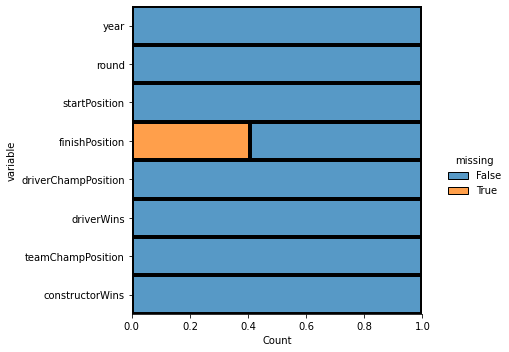

In [27]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df[num].isna().melt(value_name="missing"),
    y='variable',
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [28]:
# input missing values
df[['driverChampPosition', 'teamChampPosition', 'finishPosition']] = df[['driverChampPosition', 'teamChampPosition', 'finishPosition']].fillna(0)
df = df.dropna()

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23319 entries, 0 to 23318
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 23319 non-null  int64  
 1   round                23319 non-null  int64  
 2   gpName               23319 non-null  object 
 3   startPosition        23319 non-null  int64  
 4   finishPosition       23319 non-null  float64
 5   driverName           23319 non-null  object 
 6   constructorName      23319 non-null  object 
 7   driverChampPosition  23319 non-null  float64
 8   driverWins           23319 non-null  int64  
 9   teamChampPosition    23319 non-null  float64
 10  constructorWins      23319 non-null  int64  
 11  status               23319 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 2.3+ MB


In [30]:
df[num].head(1000)

,year,round,startPosition,finishPosition,driverChampPosition,driverWins,teamChampPosition,constructorWins
0,2009,1,1,1.0,1.0,1,1.0,1
1,2009,1,2,2.0,2.0,0,1.0,1
2,2009,2,1,1.0,1.0,2,1.0,2
3,2009,2,8,5.0,2.0,0,1.0,2
4,2009,3,5,3.0,1.0,2,1.0,2
...,...,...,...,...,...,...,...,...
995,1997,16,6,2.0,3.0,1,1.0,8
996,1997,17,1,3.0,1.0,7,1.0,8
997,1997,17,3,6.0,2.0,1,1.0,8
998,1996,1,1,2.0,2.0,0,1.0,1


In [31]:
# summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,23319.0,1992.203611,17.239735,1958.0,1978.0,1991.0,2007.0,2022.0
round,23319.0,8.697071,4.902524,1.0,5.0,8.0,13.0,22.0
startPosition,23319.0,11.061495,7.169297,0.0,5.0,11.0,17.0,32.0
finishPosition,23319.0,4.712809,5.362651,0.0,0.0,3.0,9.0,24.0
driverChampPosition,23319.0,13.896694,9.354252,0.0,6.0,13.0,20.0,83.0
driverWins,23319.0,0.359492,1.129632,0.0,0.0,0.0,0.0,13.0
teamChampPosition,23319.0,6.471761,4.023822,0.0,3.0,6.0,9.0,21.0
constructorWins,23319.0,0.783396,1.880134,0.0,0.0,0.0,1.0,19.0


In [32]:
# percentage of missing values
df.isnull().sum() / len(df) * 100

year                   0.0
round                  0.0
gpName                 0.0
startPosition          0.0
finishPosition         0.0
driverName             0.0
constructorName        0.0
driverChampPosition    0.0
driverWins             0.0
teamChampPosition      0.0
constructorWins        0.0
status                 0.0
dtype: float64

In [33]:
df.head()

,year,round,gpName,startPosition,finishPosition,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,status
0,2009,1,Australian Grand Prix,1,1.0,Jenson Button,Brawn,1.0,1,1.0,1,Finished
1,2009,1,Australian Grand Prix,2,2.0,Rubens Barrichello,Brawn,2.0,0,1.0,1,Finished
2,2009,2,Malaysian Grand Prix,1,1.0,Jenson Button,Brawn,1.0,2,1.0,2,Finished
3,2009,2,Malaysian Grand Prix,8,5.0,Rubens Barrichello,Brawn,2.0,0,1.0,2,Finished
4,2009,3,Chinese Grand Prix,5,3.0,Jenson Button,Brawn,1.0,2,1.0,2,Finished


In [34]:
df[df['driverChampPosition'] > 10]

,year,round,gpName,startPosition,finishPosition,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,status
32,2008,2,Malaysian Grand Prix,11,10.0,Jenson Button,Honda,13.0,0,9.0,0,Finished
33,2008,3,Bahrain Grand Prix,12,11.0,Rubens Barrichello,Honda,16.0,0,9.0,0,Finished
34,2008,4,Spanish Grand Prix,13,6.0,Jenson Button,Honda,12.0,0,8.0,0,Finished
35,2008,6,Monaco Grand Prix,14,6.0,Rubens Barrichello,Honda,14.0,0,9.0,0,Finished
36,2008,7,Canadian Grand Prix,20,11.0,Jenson Button,Honda,16.0,0,8.0,0,Finished
...,...,...,...,...,...,...,...,...,...,...,...,...
23311,1961,8,United States Grand Prix,19,0.0,Lloyd Ruby,Lotus-Climax,39.0,0,2.0,3,Magneto
23314,1970,12,United States Grand Prix,24,0.0,Jo Bonnier,McLaren-Ford,36.0,0,5.0,0,Water pipe
23315,1968,1,South African Grand Prix,15,0.0,Ludovico Scarfiotti,Cooper-BRM,23.0,0,13.0,0,Water pipe
23317,1964,5,British Grand Prix,20,14.0,John Taylor,Cooper-Climax,21.0,0,5.0,0,+24 Laps


In [35]:
df = df.astype({"finishPosition":'int', "driverChampPosition":'int', 'teamChampPosition':'int'})
df.dtypes

year                    int64
round                   int64
gpName                 object
startPosition           int64
finishPosition          int64
driverName             object
constructorName        object
driverChampPosition     int64
driverWins              int64
teamChampPosition       int64
constructorWins         int64
status                 object
dtype: object

In [36]:
df.shape

(23319, 12)

In [37]:
currentSeason = 2021
dff = df[df['year']>currentSeason]

currentDrivers = dff['driverName'].unique()
currentConstructors = dff['constructorName'].unique()

print(currentDrivers)
print(currentDrivers.size)

print(currentConstructors)
print(currentConstructors.size)

['Alexander Albon' 'Nicholas Latifi' 'Daniel Ricciardo' 'Lando Norris'
 'Carlos Sainz' 'Charles Leclerc' 'Fernando Alonso' 'Esteban Ocon'
 'Lewis Hamilton' 'George Russell' 'Valtteri Bottas' 'Guanyu Zhou'
 'Sergio Pérez' 'Max Verstappen' 'Lance Stroll' 'Nico Hülkenberg'
 'Kevin Magnussen' 'Mick Schumacher' 'Yuki Tsunoda' 'Pierre Gasly'
 'Sebastian Vettel']
21
['Williams' 'McLaren' 'Ferrari' 'Alpine F1 Team' 'Mercedes' 'Alfa Romeo'
 'Red Bull' 'Aston Martin' 'Haas F1 Team' 'AlphaTauri']
10


In [38]:
# filter by drivers who finished
df_finish = df[df['status'] == 'Finished']
df_finish = df_finish.drop(columns = ['status'])
cat.remove('status')

#df_current = df_finish

# filter by current drivers
df_current = df_finish.loc[df_finish['driverName'].isin(currentDrivers)]
df_current = df_current.loc[df_finish['constructorName'].isin(currentConstructors)]

df_current.head()
print(df_current['constructorName'].unique())


['Williams' 'McLaren' 'Ferrari' 'Alpine F1 Team' 'Mercedes' 'Alfa Romeo'
 'Red Bull' 'Aston Martin' 'Haas F1 Team' 'AlphaTauri']


In [39]:
df_current.shape

(1239, 11)

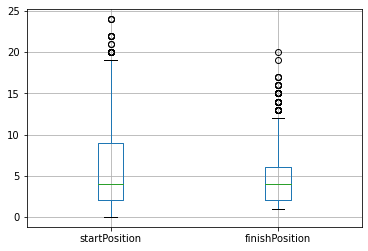

In [40]:
boxplot = df_current.boxplot(column=['startPosition', 'finishPosition'])

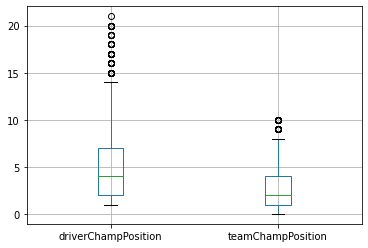

In [41]:
boxplot = df_current.boxplot(column=['driverChampPosition', 'teamChampPosition'])

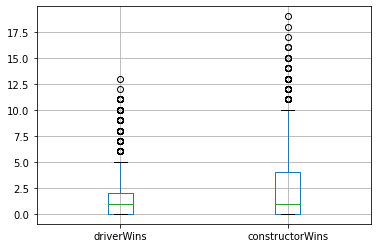

In [42]:
boxplot = df_current.boxplot(column=['driverWins', 'constructorWins'])

<AxesSubplot:xlabel='driverName', ylabel='startPosition'>

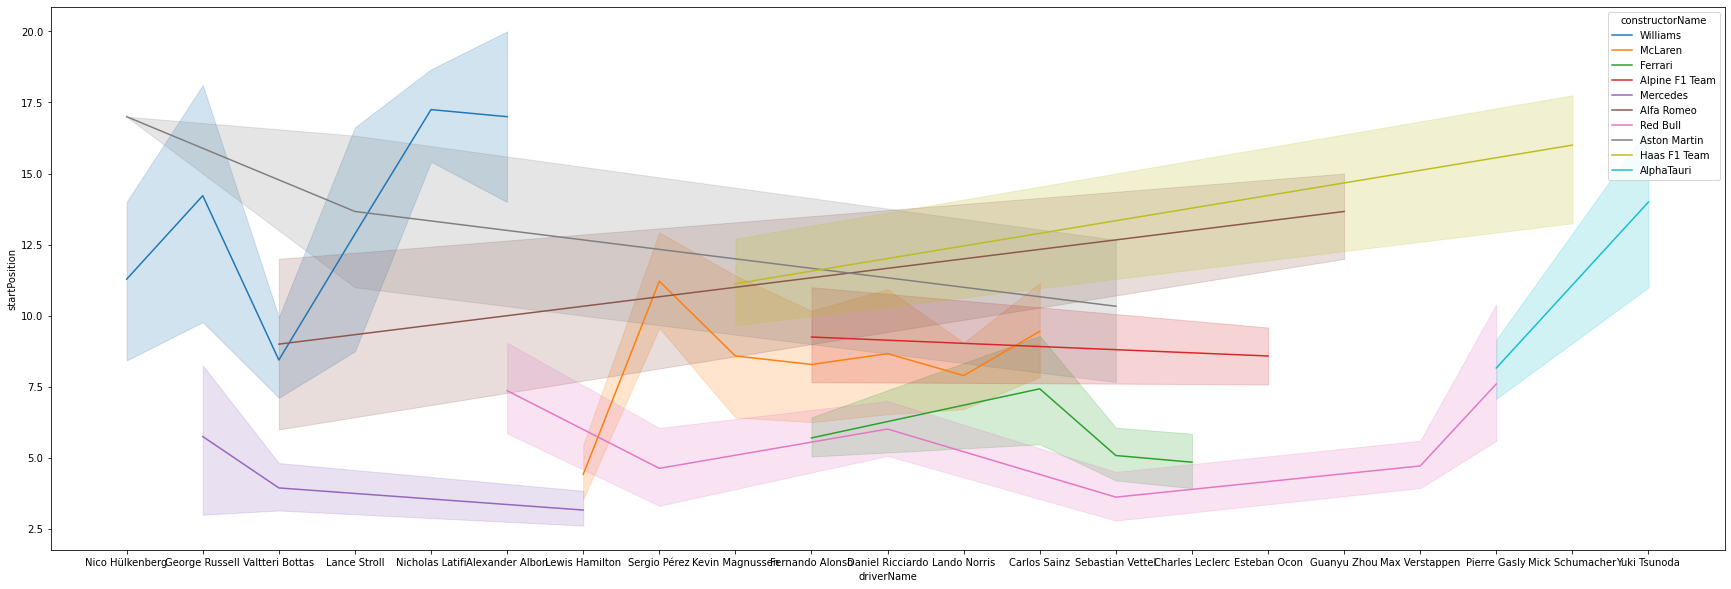

In [43]:
plt.figure(figsize=(30,10))
sns.lineplot(data=df_current, x="driverName", y="startPosition", hue="constructorName")

<AxesSubplot:xlabel='driverName', ylabel='finishPosition'>

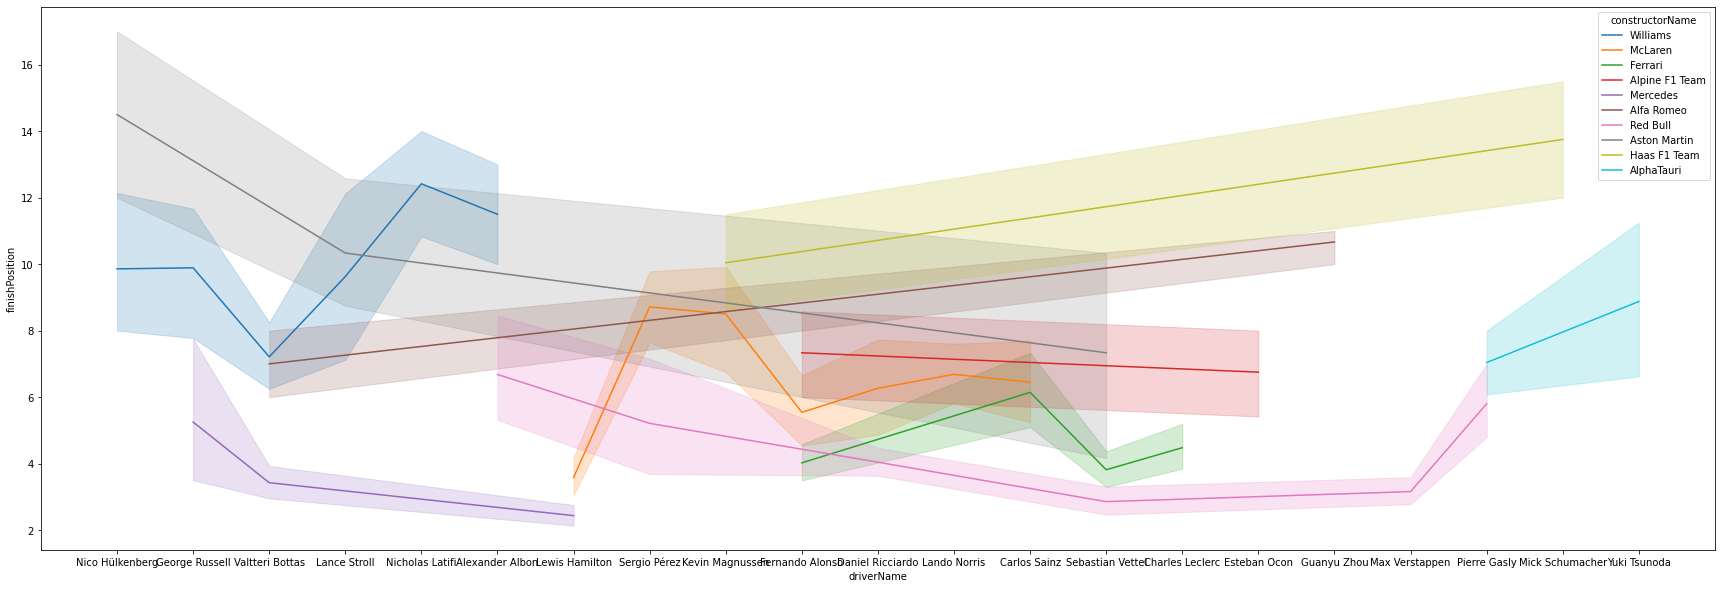

In [44]:
plt.figure(figsize=(30,10))
sns.lineplot(data=df_current, x="driverName", y="finishPosition", hue="constructorName")

<AxesSubplot:xlabel='driverName', ylabel='count'>

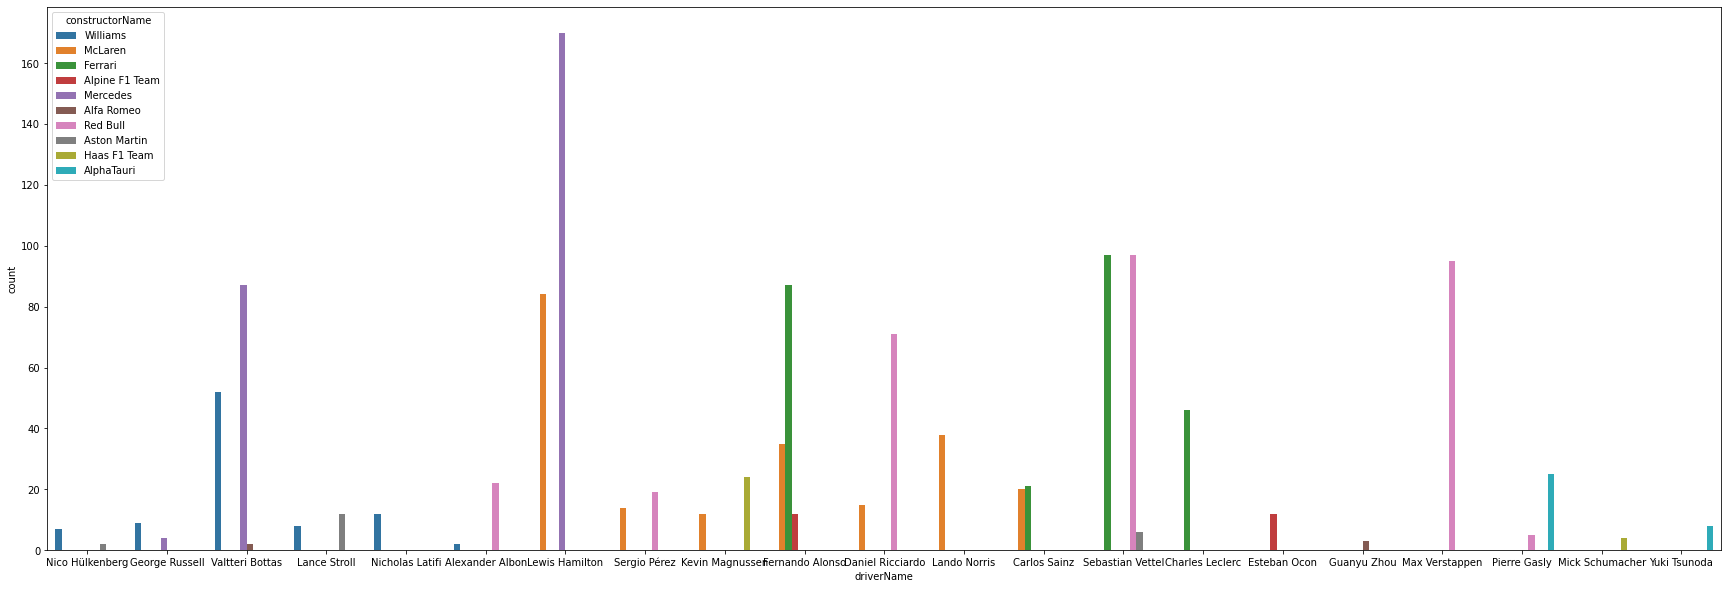

In [45]:
plt.figure(figsize=(30,10))
sns.countplot(x="driverName", hue='constructorName', data=df_current)

In [46]:
df_current.skew()

<ipython-input-46-24ff96085903>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_current.skew()


year                  -0.588384
round                  0.107479
startPosition          1.250871
finishPosition         1.168362
driverChampPosition    1.381557
driverWins             2.064895
teamChampPosition      1.346403
constructorWins        1.708534
dtype: float64

ValueError: num must be 1 <= num <= 9, not 10

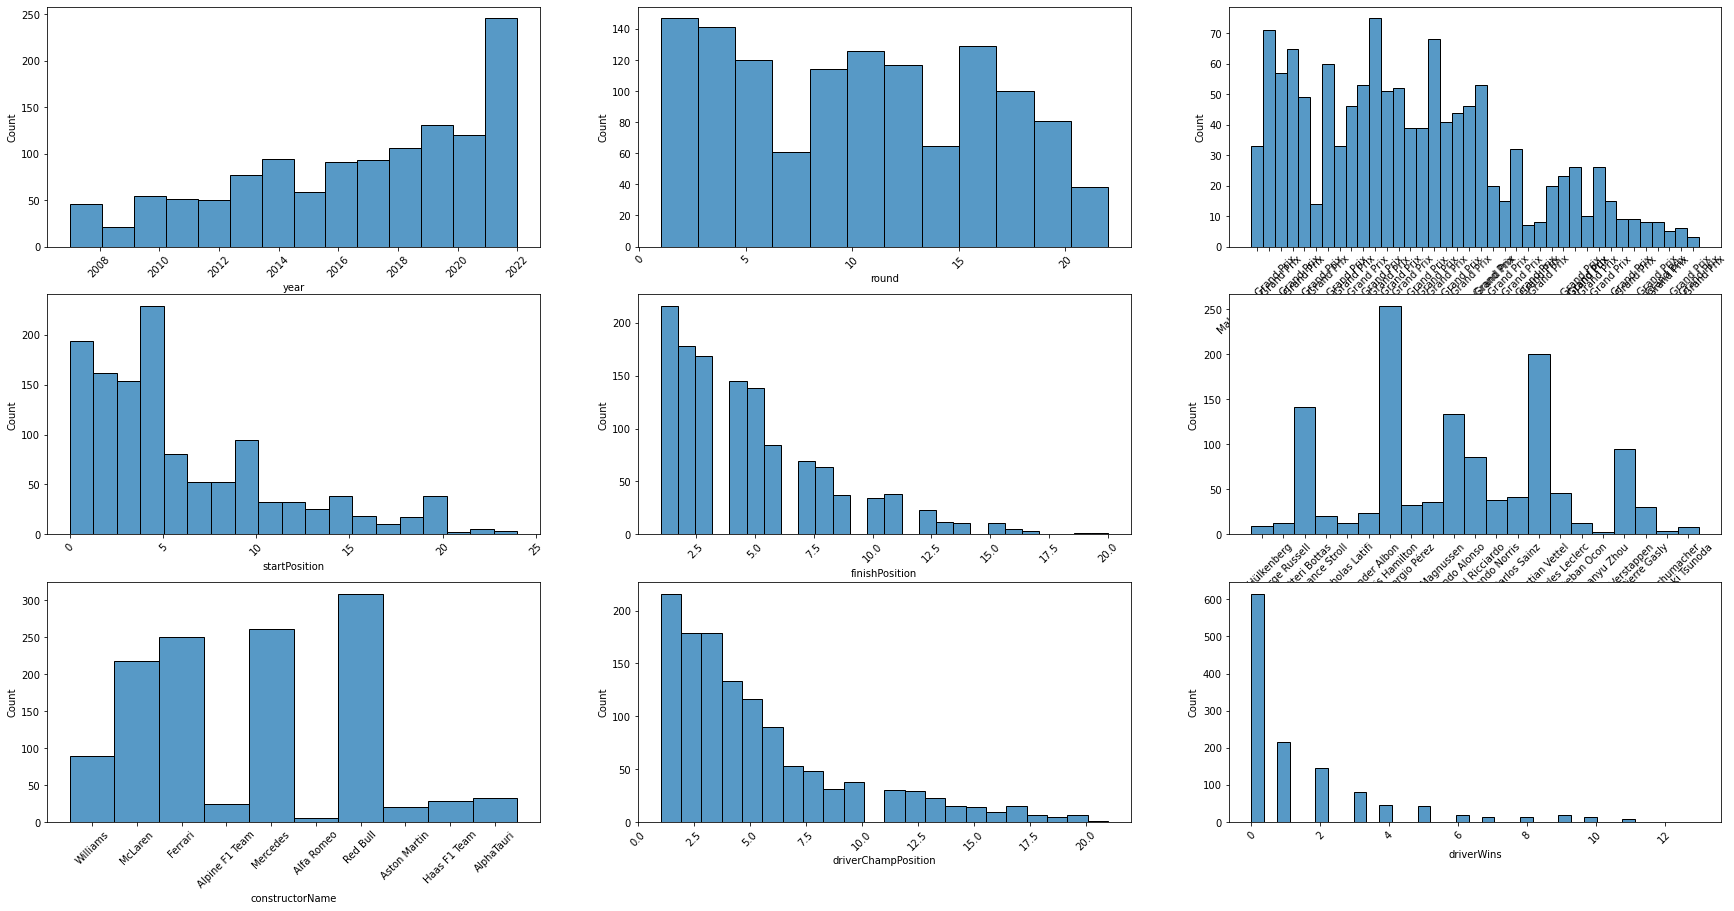

In [47]:
plt.figure(figsize=(30,15))
for i, column in enumerate(df_current.columns, 1):
    plt.subplot(3,3,i)
    plt.xticks(rotation=45)
    sns.histplot(df_current[column])


In [48]:
# outlier removal
Q1 = df_current.quantile(0.25)
Q3 = df_current.quantile(0.75)

IQR = Q3 - Q1
df_current = df_current[~((df_current<(Q1-1.5*IQR)) | (df_current>(Q3+1.5*IQR))).any(axis=1)]
df_current.skew()

<ipython-input-48-80ee48c97b4b>:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_current = df_current[~((df_current<(Q1-1.5*IQR)) | (df_current>(Q3+1.5*IQR))).any(axis=1)]
<ipython-input-48-80ee48c97b4b>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_current.skew()


year                  -0.560803
round                  0.233042
startPosition          1.155155
finishPosition         0.778643
driverChampPosition    0.989629
driverWins             1.316042
teamChampPosition      0.875090
constructorWins        1.380459
dtype: float64

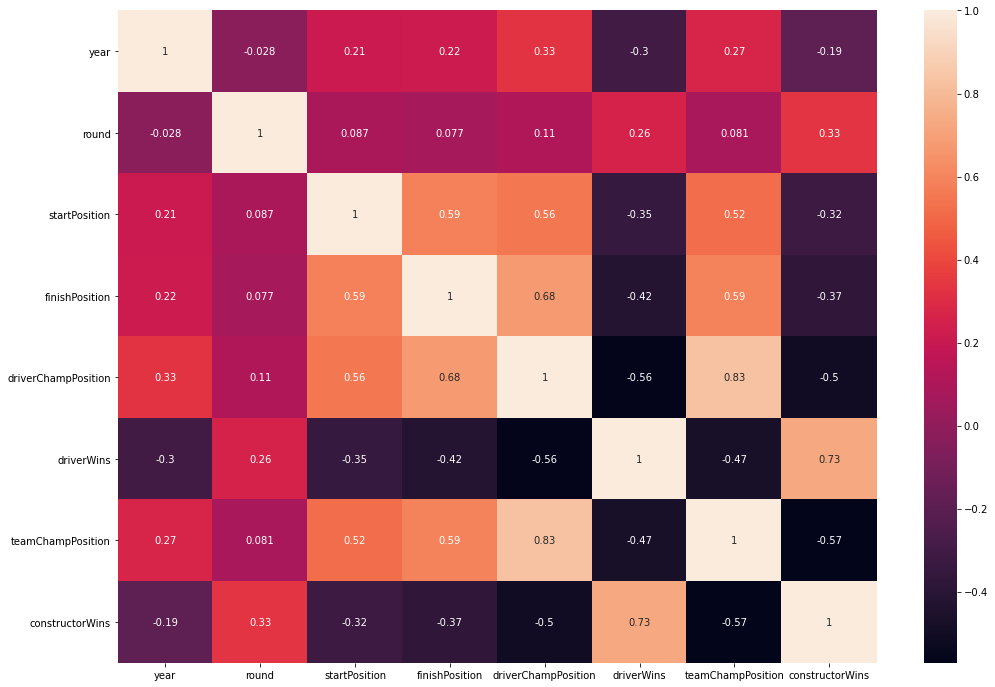

In [49]:
#correlation matrix
plt.figure(figsize=(17,12))
sns.heatmap(df_current.corr(),annot=True)
plt.show()

In [50]:
#df_current['champPosition'] = (0.5 * df_current['driverChampPosition']) + (0.5 * df_current['teamChampPosition'])
#df_current['champPosition'] = df_current['champPosition'].astype({"champPosition":'int'})
#num.append('champPosition')
#df_current['champPosition'].head(10000)

In [51]:
# the independent variables set
X = df_current[num]

# VIF dataframe
def compute_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

# calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
            for i in range(len(X.columns))]
    return vif_data

compute_vif(X)

,feature,VIF
0,year,10.053985
1,round,4.893134
2,startPosition,4.664621
3,finishPosition,7.450571
4,driverChampPosition,14.747641
5,driverWins,4.182366
6,teamChampPosition,15.206106
7,constructorWins,4.879358


In [52]:
X = df_current[num].drop(['driverChampPosition', 'year'] , axis=1)
compute_vif(X)

# dropping doesnt effect performance very much but has significant positive impact in feature evaluation

,feature,VIF
0,round,4.699482
1,startPosition,4.568755
2,finishPosition,6.447520
3,driverWins,3.454413
4,teamChampPosition,6.572930
5,constructorWins,4.255354


In [53]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_current[num]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=3, random_state=0)
label = kmeans.fit_predict(X)

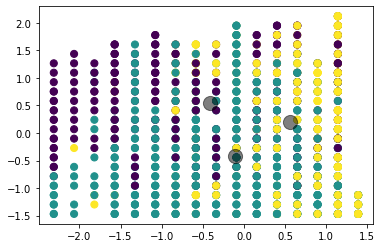

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=label, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Text(0.5, 1.0, 'Elbow curve')

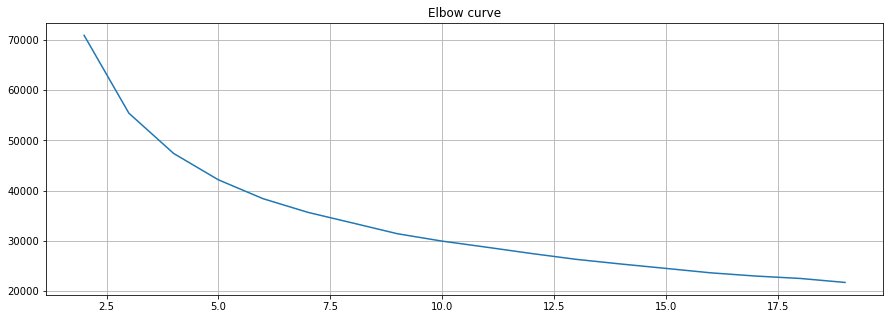

In [55]:
X = df_current[num]
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [56]:
df_current['label'] = label
num.append('label')
df_current.head(1000)

,year,round,gpName,startPosition,finishPosition,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,label
655,2010,3,Malaysian Grand Prix,5,10,Nico Hülkenberg,Williams,14,0,7,0,2
662,2010,14,Italian Grand Prix,8,7,Nico Hülkenberg,Williams,14,0,7,0,2
664,2010,15,Singapore Grand Prix,17,10,Nico Hülkenberg,Williams,14,0,7,0,2
750,2014,1,Australian Grand Prix,15,5,Valtteri Bottas,Williams,5,0,4,0,2
752,2014,2,Malaysian Grand Prix,18,8,Valtteri Bottas,Williams,8,0,4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5342,2019,5,Spanish Grand Prix,8,7,Kevin Magnussen,Haas F1 Team,7,0,6,0,2
5345,2019,11,German Grand Prix,12,8,Kevin Magnussen,Haas F1 Team,13,0,8,0,2
5361,2022,1,Bahrain Grand Prix,7,5,Kevin Magnussen,Haas F1 Team,5,0,3,0,1
5362,2022,1,Bahrain Grand Prix,12,11,Mick Schumacher,Haas F1 Team,11,0,3,0,2


In [57]:
df_current.describe().T

,count,mean,std,min,25%,50%,75%,max
year,1031.0,2016.369544,4.054987,2007.0,2013.0,2017.0,2020.0,2022.0
round,1031.0,9.598448,5.856351,1.0,4.0,9.0,14.0,22.0
startPosition,1031.0,5.511154,4.109381,0.0,2.0,4.0,8.0,19.0
finishPosition,1031.0,4.387973,2.749547,1.0,2.0,4.0,6.0,12.0
driverChampPosition,1031.0,4.761397,3.219676,1.0,2.0,4.0,6.0,14.0
driverWins,1031.0,1.050436,1.385563,0.0,0.0,0.0,2.0,5.0
teamChampPosition,1031.0,2.768186,1.652182,0.0,2.0,2.0,4.0,8.0
constructorWins,1031.0,1.890398,2.294911,0.0,0.0,1.0,3.0,10.0
label,1031.0,1.019399,0.731810,0.0,0.0,1.0,2.0,2.0


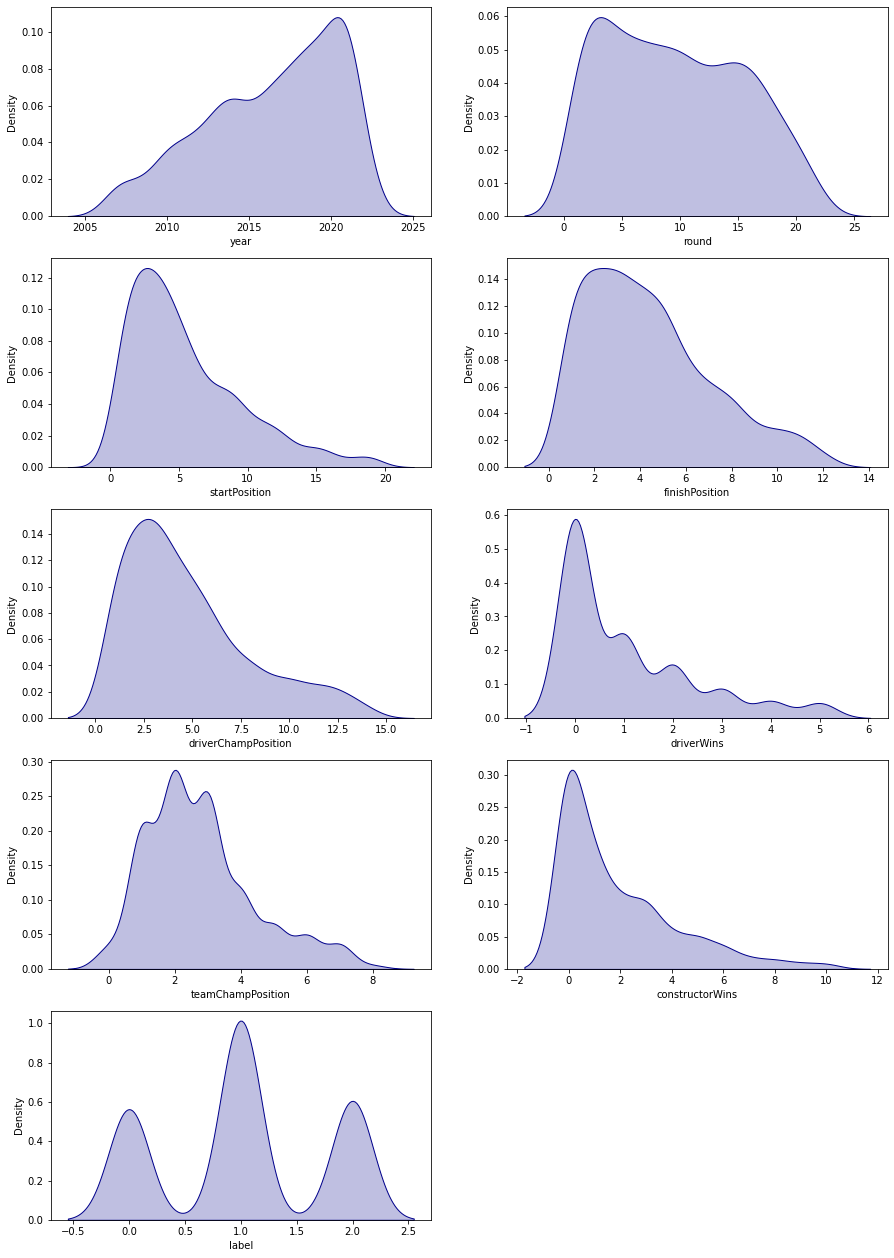

In [58]:
# kde plot for checking the normalization

plt.figure(figsize=(15,50))
for i,j in zip(num,range(1,len(num)+1)):
    plt.subplot(11,2,j)
    sns.kdeplot(df_current[i],shade=True,color='darkblue')
plt.show()

In [59]:
for i in df_current:
    print(df_current[i].value_counts())

2021    173
2019    104
2018     90
2020     89
2014     83
2016     77
2017     77
2013     59
2012     48
2010     47
2015     46
2011     40
2022     32
2007     30
2009     20
2008     16
Name: year, dtype: int64
1     70
3     69
2     67
4     58
5     56
7     56
10    56
6     54
9     52
14    52
16    51
8     51
11    47
15    47
12    45
17    45
13    42
19    33
18    30
20    22
21    19
22     9
Name: round, dtype: int64
Bahrain Grand Prix             67
British Grand Prix             62
Spanish Grand Prix             51
Italian Grand Prix             50
Belgian Grand Prix             49
Australian Grand Prix          49
Monaco Grand Prix              48
Chinese Grand Prix             47
Hungarian Grand Prix           47
Abu Dhabi Grand Prix           43
Singapore Grand Prix           39
Canadian Grand Prix            39
Austrian Grand Prix            37
Russian Grand Prix             34
United States Grand Prix       34
Japanese Grand Prix            32
Brazilian Grand

In [60]:
#df_current = df_current.drop(columns='driverName')
df_current_enc = pd.get_dummies(df_current, drop_first=True)
df_current_enc.head()

,year,round,startPosition,finishPosition,driverChampPosition,driverWins,teamChampPosition,constructorWins,label,gpName_Abu Dhabi Grand Prix,...,driverName_Yuki Tsunoda,constructorName_AlphaTauri,constructorName_Alpine F1 Team,constructorName_Aston Martin,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Red Bull,constructorName_Williams
655,2010,3,5,10,14,0,7,0,2,0,...,0,0,0,0,0,0,0,0,0,1
662,2010,14,8,7,14,0,7,0,2,0,...,0,0,0,0,0,0,0,0,0,1
664,2010,15,17,10,14,0,7,0,2,0,...,0,0,0,0,0,0,0,0,0,1
750,2014,1,15,5,5,0,4,0,2,0,...,0,0,0,0,0,0,0,0,0,1
752,2014,2,18,8,8,0,4,0,2,0,...,0,0,0,0,0,0,0,0,0,1


In [61]:
df_current_lab = df_current

le = LabelEncoder()
for i in cat:
    df_current_lab[i] = le.fit_transform(df_current[i])
df_current_lab.head()

,year,round,gpName,startPosition,finishPosition,driverName,constructorName,driverChampPosition,driverWins,teamChampPosition,constructorWins,label
655,2010,3,22,5,10,14,9,14,0,7,0,2
662,2010,14,19,8,7,14,9,14,0,7,0,2
664,2010,15,31,17,10,14,9,14,0,7,0,2
750,2014,1,2,15,5,18,9,5,0,4,0,2
752,2014,2,22,18,8,18,9,8,0,4,0,2


In [62]:

#cat.remove('driverName')
print(df_current[cat].nunique())

gpName             38
driverName         20
constructorName    10
dtype: int64


In [63]:
X = df_current_lab.drop('finishPosition',axis=1)
y = df_current_lab['finishPosition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [64]:
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# transform training data
X_train_norm = norm.transform(X_train)
# transform testing data
X_test_norm = norm.transform(X_test)

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
lin = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(lin, X_train_norm, y_train, cv=15, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.49386679 0.58728379 0.323774   0.37652406 0.73611238 0.69948333
 0.4589182  0.72251235 0.44677907 0.51810512 0.67069861 0.59186833
 0.34012335 0.49223301 0.44453108]
Average 5-Fold CV Score: 0.5268542309026385


In [66]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
#parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
#grid = GridSearchCV(linreg,parameters, cv=None)
linreg.fit(X_train_norm, y_train)
Y_pred_lin = linreg.predict(X_test_norm)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_lin))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_lin))

Mean Absolute Error (MAE): 1.433812675498393
Accuracy: 0.5060648008848488


Feature  0 :  year , Score:  -0.03364068575804243
Feature  1 :  round , Score:  0.00569460118571985
Feature  2 :  gpName , Score:  -0.009440110882460473
Feature  3 :  startPosition , Score:  0.17537440124052425
Feature  4 :  driverName , Score:  0.016239247512738975
Feature  5 :  constructorName , Score:  -0.04586923893554012
Feature  6 :  driverChampPosition , Score:  0.32621445077828576
Feature  7 :  driverWins , Score:  -0.03274452377670825
Feature  8 :  teamChampPosition , Score:  0.05137426104540463
Feature  9 :  constructorWins , Score:  0.12836512933505034
Feature  10 :  label , Score:  0.895351194619541


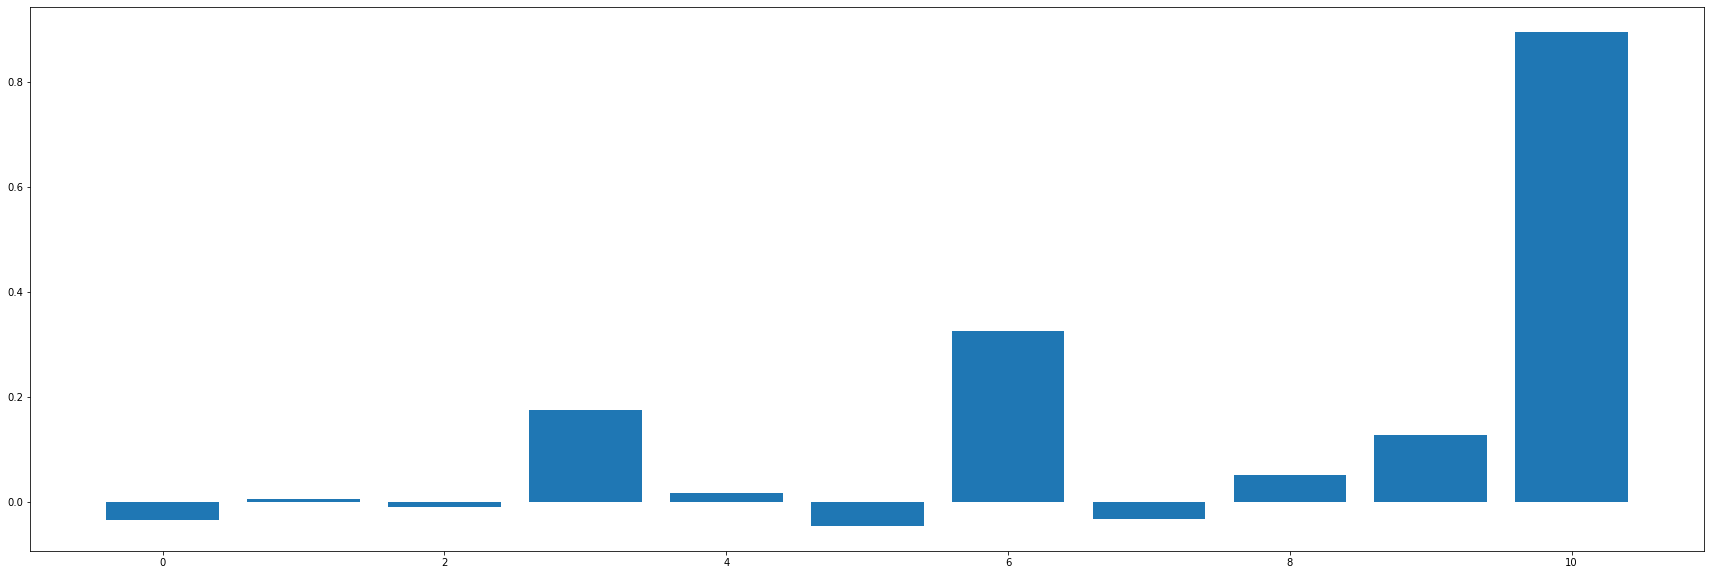

In [67]:
lin.fit(X_train, y_train)
importance = lin.coef_

for i,v in enumerate(importance):
    #if (importance[i] > 1) or (importance[i] < -1):
    print('Feature ', i,': ', X.columns[i], ', Score: ',v)

# plot feature importance
plt.figure(figsize=(30, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [68]:
X = df_current_enc.drop('finishPosition',axis=1)
y = df_current_enc['finishPosition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [69]:
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# transform training data
X_train_norm = norm.transform(X_train)
# transform testing data
X_test_norm = norm.transform(X_test)

In [70]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
rid = Ridge(alpha=0.5)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rid, X_train_norm, y_train, cv=15, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.62997673 0.40812907 0.50831608 0.57992961 0.57015611 0.38302555
 0.48453391 0.45200658 0.39934979 0.17224419 0.57717692 0.5517521
 0.33406547 0.45292981 0.69976837]
Average 5-Fold CV Score: 0.4802240191085544


In [71]:
from sklearn.linear_model import Ridge

#feed data with driverChampPosition

rid = Ridge(alpha=0.5)
rid.fit(X_train_norm, y_train)
Y_pred_rid = rid.predict(X_test_norm)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_rid))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_rid))

Mean Absolute Error (MAE): 1.3491979531121316
Accuracy: 0.496432989418089


Feature  0 :  year , Score:  -0.20990093326794454
Feature  1 :  round , Score:  -0.6697182959088471
Feature  2 :  startPosition , Score:  3.0168655957562738
Feature  3 :  driverChampPosition , Score:  3.858261770604014
Feature  4 :  driverWins , Score:  -0.09377014985826804
Feature  5 :  teamChampPosition , Score:  0.37103338125763063
Feature  6 :  constructorWins , Score:  1.8907779474555948
Feature  7 :  label , Score:  2.502504059997527
Feature  8 :  gpName_Abu Dhabi Grand Prix , Score:  0.522704322760335
Feature  9 :  gpName_Australian Grand Prix , Score:  -0.7052255850979601
Feature  10 :  gpName_Austrian Grand Prix , Score:  -0.31237520920333584
Feature  11 :  gpName_Azerbaijan Grand Prix , Score:  -0.5629721222569447
Feature  12 :  gpName_Bahrain Grand Prix , Score:  -0.21966186388569767
Feature  13 :  gpName_Belgian Grand Prix , Score:  0.4303293761426308
Feature  14 :  gpName_Brazilian Grand Prix , Score:  0.8044792947639182
Feature  15 :  gpName_British Grand Prix , Score:  -

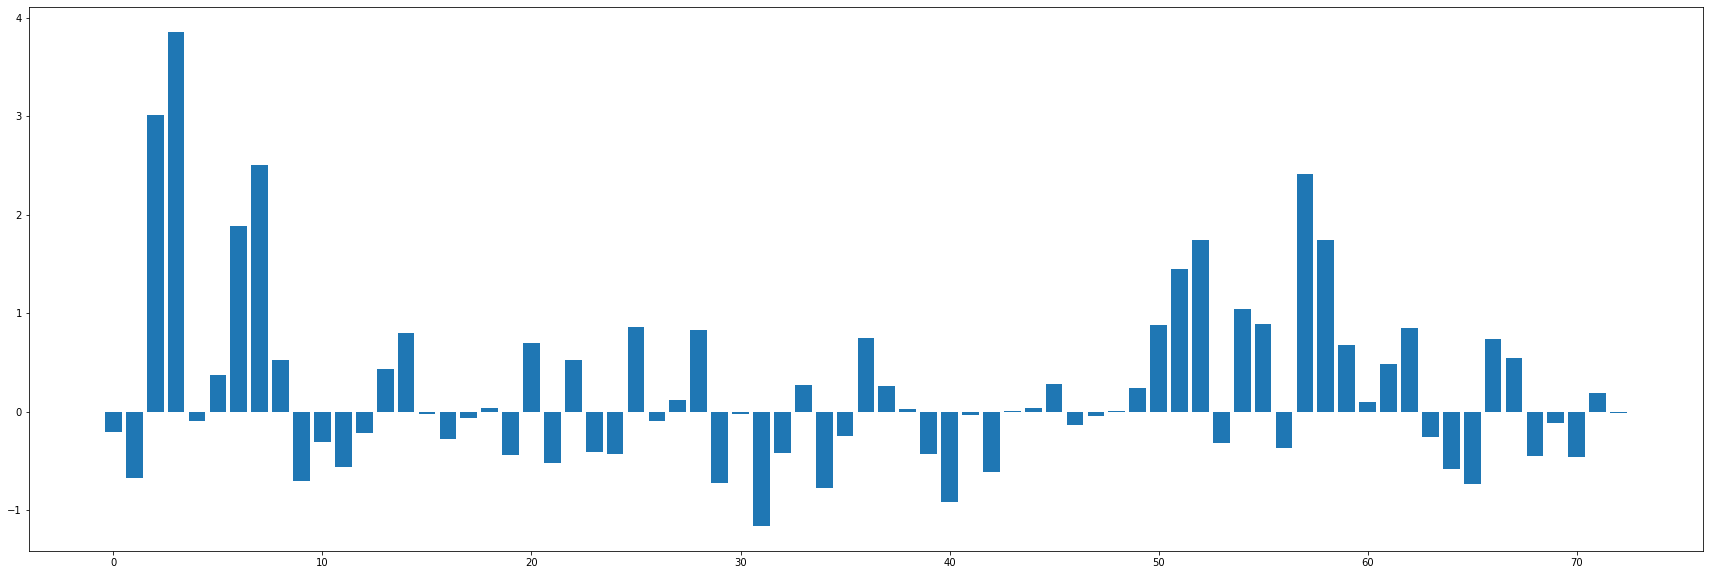

In [72]:
importance = rid.coef_

#print(X.columns)

for i,v in enumerate(importance):
    #if (importance[i] > 1) or (importance[i] < -1):
    print('Feature ', i,': ', X.columns[i], ', Score: ',v)

# plot feature importance
plt.figure(figsize=(30, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [86]:
print("Driver Importance: ", mean(np.square(importance[9:45])))
print("Track Importance: ", mean(np.square(importance[45:63])))
print("Team Importance: ", mean(np.square(importance[63:])))

Driver Importance:  0.26987904666474866
Track Importance:  1.0251357947735862
Team Importance:  0.2260076650344301


In [74]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
SVR = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(SVR, X_train_norm, y_train, cv=15, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.65731162 0.40695014 0.49000222 0.53234209 0.54027816 0.43104198
 0.47420804 0.46233062 0.34231441 0.08977281 0.51988613 0.58514527
 0.3265471  0.43962783 0.7129585 ]
Average 5-Fold CV Score: 0.4673811290205256


In [75]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

SVR = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, kernel='linear'))
SVR.fit(X_train_norm, y_train)
Y_pred_SVR = SVR.predict(X_test_norm)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_SVR))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_SVR))

Mean Absolute Error (MAE): 1.3025858888234376
Accuracy: 0.511006434948015


In [76]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
neigh = KNeighborsRegressor(n_neighbors=21)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(neigh, X_train_norm, y_train, cv=15, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.51782414 0.21691909 0.37665551 0.42671684 0.49558801 0.31512713
 0.56046253 0.50098444 0.32799739 0.18598208 0.43331531 0.50851129
 0.16689853 0.29569602 0.59971461]
Average 5-Fold CV Score: 0.39522619384246815


In [77]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=21)
neigh.fit(X_train_norm, y_train)
Y_pred_neigh = neigh.predict(X_test_norm)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_neigh))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_neigh))

Mean Absolute Error (MAE): 1.448585231193927
Accuracy: 0.45009047936519075


In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

MLP = MLPRegressor(random_state=42, max_iter=100000, solver='adam')

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(MLP, X_train, y_train, cv=15, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

/Users/matteoparry/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[0.62333047 0.39501128 0.51531045 0.55412452 0.60191627 0.36311371
 0.52744516 0.53530251 0.37894963 0.12781986 0.54056479 0.61848982
 0.29361058 0.37506525 0.69017386]
Average 5-Fold CV Score: 0.47601521079329806


In [79]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(random_state=1, max_iter=100000)
MLP.fit(X_train, y_train)
Y_pred_MLP = MLP.predict(X_test)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_MLP))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_MLP))

Mean Absolute Error (MAE): 1.3377718295923804
Accuracy: 0.5292154176416843


In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
rf = RandomForestRegressor(random_state=1)

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(rf, X_train_norm, y_train, cv=10, scoring='r2')

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.60483692 0.48851613 0.55379306 0.62499932 0.48325843 0.42502004
 0.35509641 0.66352416 0.33788056 0.71634422]
Average 5-Fold CV Score: 0.5253269247906879


In [81]:
from sklearn.ensemble import RandomForestRegressor

rf_regr = RandomForestRegressor(random_state=1)
rf_regr.fit(X_train_norm, y_train)
Y_pred_rf = rf_regr.predict(X_test_norm)

print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test,Y_pred_rf))
print('Accuracy:', metrics.r2_score(y_test,Y_pred_rf))

Mean Absolute Error (MAE): 1.3299033816425119
Accuracy: 0.5290886188989088


In [82]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [83]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 4)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/matteoparry/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfclf = RandomForestClassifier( random_state=0)
rfclf = rfclf.fit(X_train_norm, y_train)
Y_pred_rfclf = rfclf.predict(X_test_norm)


print("Accuracy:",metrics.accuracy_score(y_test, Y_pred_rfclf))